<a href="https://colab.research.google.com/github/xmagnetisx/Fashion-Designs/blob/master/Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

from __future__  import print_function, division

#import keras and tensorflow backend
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

In [0]:
#import for plotting and data preprocessing
import matplotlib.pyplot as plt
import sys
import numpy as np


In [0]:
#Create GAN class function
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        #Use the adam optimizer algorithm instead of gradient descent
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Instantiate the generator to self
        self.generator = self.build_generator()

        # Input noise into the generator to create new images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # Disable the discriminator from being trained
        self.discriminator.trainable = False

        # determine validity of the generated images
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

#build generator function
    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

#build discriminator function
    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

#training function
    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

#Train Discriminator

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#Train Generator
            #Create random noise 
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

#Show sample images
    def sample_images(self, epoch):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.755090, acc.: 54.69%] [G loss: 0.702438]


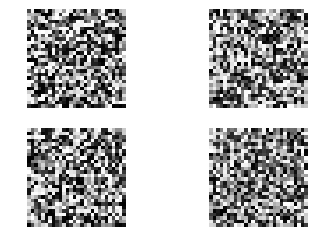

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.425986, acc.: 76.56%] [G loss: 0.762394]
2 [D loss: 0.390673, acc.: 75.00%] [G loss: 0.867887]
3 [D loss: 0.278369, acc.: 92.19%] [G loss: 0.970226]
4 [D loss: 0.287336, acc.: 90.62%] [G loss: 1.197426]
5 [D loss: 0.240831, acc.: 95.31%] [G loss: 1.249560]
6 [D loss: 0.230989, acc.: 96.88%] [G loss: 1.272395]
7 [D loss: 0.235945, acc.: 92.19%] [G loss: 1.511967]
8 [D loss: 0.179923, acc.: 98.44%] [G loss: 1.614114]
9 [D loss: 0.152834, acc.: 98.44%] [G loss: 1.627846]
10 [D loss: 0.147379, acc.: 98.44%] [G loss: 1.752891]
11 [D loss: 0.159685, acc.: 98.44%] [G loss: 1.852446]
12 [D loss: 0.140130, acc.: 100.00%] [G loss: 2.057005]
13 [D loss: 0.111251, acc.: 100.00%] [G loss: 2.049192]
14 [D loss: 0.104938, acc.: 100.00%] [G loss: 2.152726]
15 [D loss: 0.079812, acc.: 100.00%] [G loss: 2.224236]
16 [D loss: 0.073354, acc.: 100.00%] [G loss: 2.220498]
17 [D loss: 0.095802, acc.: 100.00%] [G loss: 2.394704]
18 [D loss: 0.089722, acc.: 100.00%] [G loss: 2.505903]
19 [D loss: 

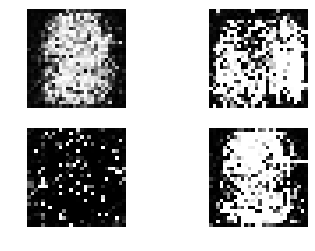

301 [D loss: 0.504495, acc.: 78.12%] [G loss: 2.822174]
302 [D loss: 0.451186, acc.: 76.56%] [G loss: 2.882553]
303 [D loss: 0.458213, acc.: 75.00%] [G loss: 2.921545]
304 [D loss: 0.584396, acc.: 70.31%] [G loss: 3.085911]
305 [D loss: 0.607629, acc.: 68.75%] [G loss: 2.255371]
306 [D loss: 0.371334, acc.: 81.25%] [G loss: 3.245205]
307 [D loss: 0.418610, acc.: 78.12%] [G loss: 3.023100]
308 [D loss: 0.407477, acc.: 79.69%] [G loss: 2.496407]
309 [D loss: 0.385269, acc.: 82.81%] [G loss: 3.099948]
310 [D loss: 0.384638, acc.: 85.94%] [G loss: 2.773582]
311 [D loss: 0.588185, acc.: 75.00%] [G loss: 2.911761]
312 [D loss: 0.391567, acc.: 81.25%] [G loss: 2.748581]
313 [D loss: 0.388096, acc.: 84.38%] [G loss: 2.116847]
314 [D loss: 0.346118, acc.: 87.50%] [G loss: 3.198596]
315 [D loss: 0.448672, acc.: 71.88%] [G loss: 2.801363]
316 [D loss: 0.325144, acc.: 87.50%] [G loss: 3.260196]
317 [D loss: 0.788389, acc.: 57.81%] [G loss: 3.047602]
318 [D loss: 0.240486, acc.: 92.19%] [G loss: 3.

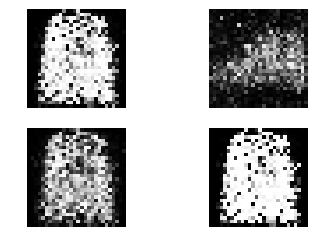

601 [D loss: 0.538160, acc.: 70.31%] [G loss: 1.392049]
602 [D loss: 0.512701, acc.: 75.00%] [G loss: 1.452322]
603 [D loss: 0.614343, acc.: 71.88%] [G loss: 1.229220]
604 [D loss: 0.601160, acc.: 65.62%] [G loss: 1.315474]
605 [D loss: 0.532943, acc.: 65.62%] [G loss: 1.519732]
606 [D loss: 0.660952, acc.: 59.38%] [G loss: 1.283701]
607 [D loss: 0.783716, acc.: 50.00%] [G loss: 1.429652]
608 [D loss: 0.507909, acc.: 71.88%] [G loss: 1.567793]
609 [D loss: 0.671195, acc.: 59.38%] [G loss: 1.285857]
610 [D loss: 0.610464, acc.: 68.75%] [G loss: 1.320466]
611 [D loss: 0.625205, acc.: 62.50%] [G loss: 1.420254]
612 [D loss: 0.549677, acc.: 78.12%] [G loss: 1.475261]
613 [D loss: 0.622435, acc.: 65.62%] [G loss: 1.323416]
614 [D loss: 0.602264, acc.: 68.75%] [G loss: 1.531591]
615 [D loss: 0.573995, acc.: 65.62%] [G loss: 1.271374]
616 [D loss: 0.685319, acc.: 46.88%] [G loss: 1.194853]
617 [D loss: 0.732752, acc.: 54.69%] [G loss: 1.254401]
618 [D loss: 0.532586, acc.: 73.44%] [G loss: 1.

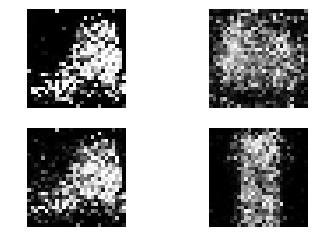

901 [D loss: 0.708049, acc.: 53.12%] [G loss: 1.006642]
902 [D loss: 0.578930, acc.: 67.19%] [G loss: 1.063864]
903 [D loss: 0.653991, acc.: 60.94%] [G loss: 1.057436]
904 [D loss: 0.696267, acc.: 51.56%] [G loss: 1.154932]
905 [D loss: 0.701694, acc.: 64.06%] [G loss: 1.049159]
906 [D loss: 0.650163, acc.: 64.06%] [G loss: 0.964632]
907 [D loss: 0.715112, acc.: 53.12%] [G loss: 1.007589]
908 [D loss: 0.600229, acc.: 70.31%] [G loss: 0.998265]
909 [D loss: 0.715673, acc.: 68.75%] [G loss: 0.922349]
910 [D loss: 0.654739, acc.: 60.94%] [G loss: 0.997951]
911 [D loss: 0.683303, acc.: 60.94%] [G loss: 1.091658]
912 [D loss: 0.612456, acc.: 64.06%] [G loss: 1.022807]
913 [D loss: 0.653924, acc.: 62.50%] [G loss: 1.186218]
914 [D loss: 0.680498, acc.: 59.38%] [G loss: 0.967141]
915 [D loss: 0.660269, acc.: 56.25%] [G loss: 0.913589]
916 [D loss: 0.596144, acc.: 67.19%] [G loss: 1.107634]
917 [D loss: 0.685625, acc.: 57.81%] [G loss: 0.943746]
918 [D loss: 0.645512, acc.: 57.81%] [G loss: 0.

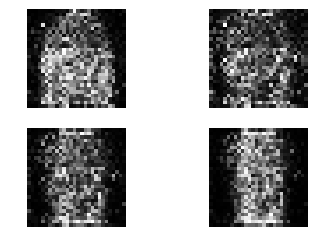

1201 [D loss: 0.651964, acc.: 62.50%] [G loss: 0.934610]
1202 [D loss: 0.713935, acc.: 42.19%] [G loss: 0.962993]
1203 [D loss: 0.694813, acc.: 43.75%] [G loss: 0.939315]
1204 [D loss: 0.677997, acc.: 51.56%] [G loss: 0.882840]
1205 [D loss: 0.648569, acc.: 54.69%] [G loss: 0.948247]
1206 [D loss: 0.629312, acc.: 64.06%] [G loss: 0.978478]
1207 [D loss: 0.702340, acc.: 57.81%] [G loss: 0.891025]
1208 [D loss: 0.698590, acc.: 56.25%] [G loss: 1.013872]
1209 [D loss: 0.726483, acc.: 50.00%] [G loss: 0.932526]
1210 [D loss: 0.628694, acc.: 59.38%] [G loss: 1.054940]
1211 [D loss: 0.774026, acc.: 35.94%] [G loss: 0.862773]
1212 [D loss: 0.660476, acc.: 59.38%] [G loss: 0.802843]
1213 [D loss: 0.682239, acc.: 65.62%] [G loss: 0.899980]
1214 [D loss: 0.640873, acc.: 64.06%] [G loss: 0.964054]
1215 [D loss: 0.652991, acc.: 60.94%] [G loss: 0.983529]
1216 [D loss: 0.658772, acc.: 62.50%] [G loss: 1.041412]
1217 [D loss: 0.709506, acc.: 54.69%] [G loss: 0.927766]
1218 [D loss: 0.725075, acc.: 4

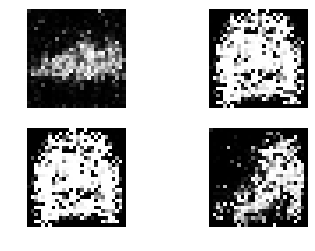

1501 [D loss: 0.673619, acc.: 54.69%] [G loss: 0.851486]
1502 [D loss: 0.665286, acc.: 54.69%] [G loss: 0.863564]
1503 [D loss: 0.599733, acc.: 64.06%] [G loss: 0.968518]
1504 [D loss: 0.621691, acc.: 62.50%] [G loss: 0.857026]
1505 [D loss: 0.637868, acc.: 48.44%] [G loss: 0.895007]
1506 [D loss: 0.638629, acc.: 62.50%] [G loss: 0.955469]
1507 [D loss: 0.705717, acc.: 57.81%] [G loss: 0.869299]
1508 [D loss: 0.651163, acc.: 64.06%] [G loss: 0.889093]
1509 [D loss: 0.669667, acc.: 64.06%] [G loss: 0.821150]
1510 [D loss: 0.640597, acc.: 62.50%] [G loss: 0.846847]
1511 [D loss: 0.627912, acc.: 67.19%] [G loss: 0.847731]
1512 [D loss: 0.641032, acc.: 62.50%] [G loss: 0.899555]
1513 [D loss: 0.657329, acc.: 62.50%] [G loss: 0.946111]
1514 [D loss: 0.616907, acc.: 67.19%] [G loss: 1.035530]
1515 [D loss: 0.568468, acc.: 76.56%] [G loss: 1.005390]
1516 [D loss: 0.659336, acc.: 60.94%] [G loss: 0.927738]
1517 [D loss: 0.646628, acc.: 60.94%] [G loss: 0.889353]
1518 [D loss: 0.660953, acc.: 5

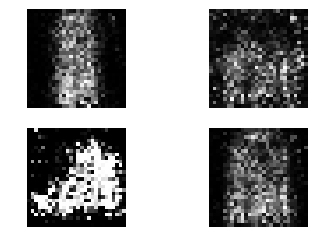

1801 [D loss: 0.703230, acc.: 50.00%] [G loss: 0.954494]
1802 [D loss: 0.692987, acc.: 50.00%] [G loss: 0.800759]
1803 [D loss: 0.685146, acc.: 50.00%] [G loss: 0.816487]
1804 [D loss: 0.688503, acc.: 56.25%] [G loss: 0.816372]
1805 [D loss: 0.728943, acc.: 50.00%] [G loss: 0.793505]
1806 [D loss: 0.632850, acc.: 64.06%] [G loss: 0.817133]
1807 [D loss: 0.718550, acc.: 53.12%] [G loss: 0.906907]
1808 [D loss: 0.657241, acc.: 57.81%] [G loss: 0.871428]
1809 [D loss: 0.656032, acc.: 54.69%] [G loss: 0.913637]
1810 [D loss: 0.667468, acc.: 48.44%] [G loss: 0.820085]
1811 [D loss: 0.721349, acc.: 43.75%] [G loss: 0.916114]
1812 [D loss: 0.696756, acc.: 53.12%] [G loss: 0.915143]
1813 [D loss: 0.670039, acc.: 57.81%] [G loss: 0.918534]
1814 [D loss: 0.650015, acc.: 73.44%] [G loss: 0.864256]
1815 [D loss: 0.630676, acc.: 70.31%] [G loss: 0.871339]
1816 [D loss: 0.628281, acc.: 60.94%] [G loss: 0.882778]
1817 [D loss: 0.633056, acc.: 51.56%] [G loss: 0.905898]
1818 [D loss: 0.622014, acc.: 5

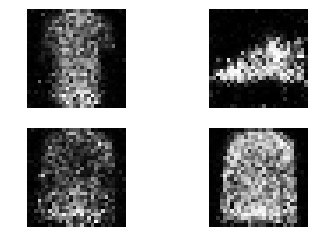

2101 [D loss: 0.700547, acc.: 53.12%] [G loss: 0.836833]
2102 [D loss: 0.622998, acc.: 64.06%] [G loss: 0.844500]
2103 [D loss: 0.657231, acc.: 54.69%] [G loss: 0.780130]
2104 [D loss: 0.684453, acc.: 53.12%] [G loss: 0.791575]
2105 [D loss: 0.624032, acc.: 60.94%] [G loss: 0.837155]
2106 [D loss: 0.652840, acc.: 53.12%] [G loss: 0.845317]
2107 [D loss: 0.610866, acc.: 64.06%] [G loss: 0.841868]
2108 [D loss: 0.670433, acc.: 59.38%] [G loss: 0.860707]
2109 [D loss: 0.669548, acc.: 57.81%] [G loss: 0.820994]
2110 [D loss: 0.667759, acc.: 59.38%] [G loss: 0.829001]
2111 [D loss: 0.634028, acc.: 57.81%] [G loss: 0.830289]
2112 [D loss: 0.668418, acc.: 51.56%] [G loss: 0.837360]
2113 [D loss: 0.655927, acc.: 56.25%] [G loss: 0.779143]
2114 [D loss: 0.633436, acc.: 54.69%] [G loss: 0.831704]
2115 [D loss: 0.622437, acc.: 59.38%] [G loss: 0.834844]
2116 [D loss: 0.686857, acc.: 54.69%] [G loss: 0.868915]
2117 [D loss: 0.691063, acc.: 51.56%] [G loss: 0.803945]
2118 [D loss: 0.670020, acc.: 5

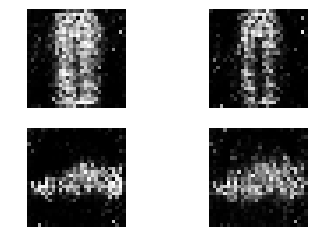

2401 [D loss: 0.657279, acc.: 59.38%] [G loss: 0.870198]
2402 [D loss: 0.730632, acc.: 45.31%] [G loss: 0.905858]
2403 [D loss: 0.691434, acc.: 54.69%] [G loss: 0.885752]
2404 [D loss: 0.659882, acc.: 54.69%] [G loss: 0.943983]
2405 [D loss: 0.656926, acc.: 62.50%] [G loss: 0.902715]
2406 [D loss: 0.660077, acc.: 54.69%] [G loss: 0.851552]
2407 [D loss: 0.663169, acc.: 50.00%] [G loss: 0.898154]
2408 [D loss: 0.654100, acc.: 48.44%] [G loss: 0.881220]
2409 [D loss: 0.648136, acc.: 53.12%] [G loss: 0.881554]
2410 [D loss: 0.660415, acc.: 53.12%] [G loss: 0.858778]
2411 [D loss: 0.633599, acc.: 62.50%] [G loss: 0.896248]
2412 [D loss: 0.699020, acc.: 53.12%] [G loss: 0.971063]
2413 [D loss: 0.679627, acc.: 51.56%] [G loss: 0.909990]
2414 [D loss: 0.681830, acc.: 53.12%] [G loss: 0.944933]
2415 [D loss: 0.657412, acc.: 62.50%] [G loss: 0.911896]
2416 [D loss: 0.623201, acc.: 68.75%] [G loss: 0.922979]
2417 [D loss: 0.627987, acc.: 60.94%] [G loss: 0.897290]
2418 [D loss: 0.696081, acc.: 5

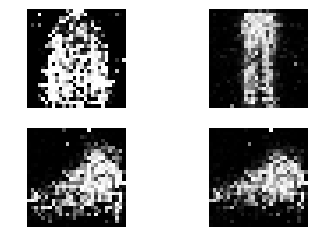

2701 [D loss: 0.633622, acc.: 65.62%] [G loss: 1.006612]
2702 [D loss: 0.701402, acc.: 51.56%] [G loss: 0.931121]
2703 [D loss: 0.653348, acc.: 60.94%] [G loss: 0.876794]
2704 [D loss: 0.656966, acc.: 59.38%] [G loss: 0.884107]
2705 [D loss: 0.642827, acc.: 71.88%] [G loss: 0.894947]
2706 [D loss: 0.610702, acc.: 70.31%] [G loss: 0.920663]
2707 [D loss: 0.629436, acc.: 62.50%] [G loss: 0.943427]
2708 [D loss: 0.644497, acc.: 60.94%] [G loss: 0.979977]
2709 [D loss: 0.642732, acc.: 62.50%] [G loss: 0.996307]
2710 [D loss: 0.662381, acc.: 59.38%] [G loss: 0.967789]
2711 [D loss: 0.724401, acc.: 40.62%] [G loss: 0.908431]
2712 [D loss: 0.665936, acc.: 57.81%] [G loss: 0.828072]
2713 [D loss: 0.633541, acc.: 65.62%] [G loss: 0.947356]
2714 [D loss: 0.694060, acc.: 57.81%] [G loss: 0.934989]
2715 [D loss: 0.687743, acc.: 48.44%] [G loss: 0.959275]
2716 [D loss: 0.660191, acc.: 62.50%] [G loss: 0.902128]
2717 [D loss: 0.570256, acc.: 75.00%] [G loss: 0.928722]
2718 [D loss: 0.713103, acc.: 5

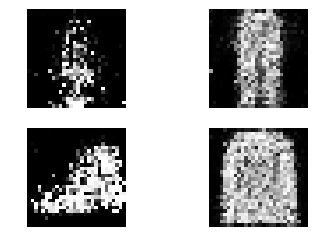

3001 [D loss: 0.708099, acc.: 46.88%] [G loss: 0.837182]
3002 [D loss: 0.632943, acc.: 56.25%] [G loss: 0.841941]
3003 [D loss: 0.658748, acc.: 54.69%] [G loss: 0.910171]
3004 [D loss: 0.670674, acc.: 48.44%] [G loss: 0.843732]
3005 [D loss: 0.682981, acc.: 50.00%] [G loss: 0.801750]
3006 [D loss: 0.705705, acc.: 50.00%] [G loss: 0.776357]
3007 [D loss: 0.622705, acc.: 64.06%] [G loss: 0.977616]
3008 [D loss: 0.610374, acc.: 67.19%] [G loss: 0.862608]
3009 [D loss: 0.659652, acc.: 59.38%] [G loss: 0.944134]
3010 [D loss: 0.678247, acc.: 50.00%] [G loss: 0.917552]
3011 [D loss: 0.660077, acc.: 57.81%] [G loss: 0.920733]
3012 [D loss: 0.667120, acc.: 59.38%] [G loss: 0.921064]
3013 [D loss: 0.626069, acc.: 65.62%] [G loss: 0.943617]
3014 [D loss: 0.634215, acc.: 62.50%] [G loss: 0.955100]
3015 [D loss: 0.629972, acc.: 62.50%] [G loss: 0.941667]
3016 [D loss: 0.666599, acc.: 56.25%] [G loss: 0.940766]
3017 [D loss: 0.612054, acc.: 68.75%] [G loss: 0.914846]
3018 [D loss: 0.705912, acc.: 5

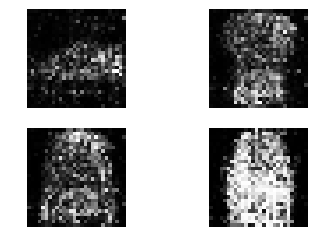

3301 [D loss: 0.704242, acc.: 51.56%] [G loss: 0.858036]
3302 [D loss: 0.646043, acc.: 65.62%] [G loss: 0.905114]
3303 [D loss: 0.670388, acc.: 62.50%] [G loss: 0.840729]
3304 [D loss: 0.645276, acc.: 54.69%] [G loss: 0.887474]
3305 [D loss: 0.719113, acc.: 50.00%] [G loss: 0.962818]
3306 [D loss: 0.685702, acc.: 57.81%] [G loss: 0.968093]
3307 [D loss: 0.624552, acc.: 64.06%] [G loss: 0.939312]
3308 [D loss: 0.657381, acc.: 59.38%] [G loss: 0.954991]
3309 [D loss: 0.648061, acc.: 60.94%] [G loss: 0.942968]
3310 [D loss: 0.632440, acc.: 60.94%] [G loss: 0.971880]
3311 [D loss: 0.660173, acc.: 56.25%] [G loss: 0.883239]
3312 [D loss: 0.683265, acc.: 60.94%] [G loss: 0.807147]
3313 [D loss: 0.680961, acc.: 59.38%] [G loss: 0.903370]
3314 [D loss: 0.732687, acc.: 48.44%] [G loss: 0.893995]
3315 [D loss: 0.587266, acc.: 62.50%] [G loss: 0.888209]
3316 [D loss: 0.646999, acc.: 62.50%] [G loss: 0.921642]
3317 [D loss: 0.680348, acc.: 54.69%] [G loss: 0.894938]
3318 [D loss: 0.698730, acc.: 5

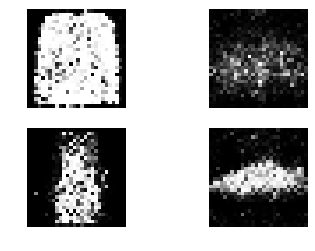

3601 [D loss: 0.737878, acc.: 40.62%] [G loss: 0.910935]
3602 [D loss: 0.621974, acc.: 60.94%] [G loss: 0.874655]
3603 [D loss: 0.620566, acc.: 64.06%] [G loss: 0.847977]
3604 [D loss: 0.630786, acc.: 56.25%] [G loss: 0.912921]
3605 [D loss: 0.656529, acc.: 54.69%] [G loss: 0.883132]
3606 [D loss: 0.661194, acc.: 62.50%] [G loss: 0.901138]
3607 [D loss: 0.623018, acc.: 67.19%] [G loss: 0.899415]
3608 [D loss: 0.657184, acc.: 56.25%] [G loss: 0.903021]
3609 [D loss: 0.666734, acc.: 57.81%] [G loss: 0.946138]
3610 [D loss: 0.683968, acc.: 53.12%] [G loss: 0.955751]
3611 [D loss: 0.618978, acc.: 60.94%] [G loss: 1.055222]
3612 [D loss: 0.664316, acc.: 60.94%] [G loss: 0.921399]
3613 [D loss: 0.670890, acc.: 51.56%] [G loss: 0.858577]
3614 [D loss: 0.569068, acc.: 73.44%] [G loss: 0.861303]
3615 [D loss: 0.641279, acc.: 62.50%] [G loss: 0.897738]
3616 [D loss: 0.617176, acc.: 64.06%] [G loss: 0.920089]
3617 [D loss: 0.613621, acc.: 64.06%] [G loss: 0.937735]
3618 [D loss: 0.608558, acc.: 7

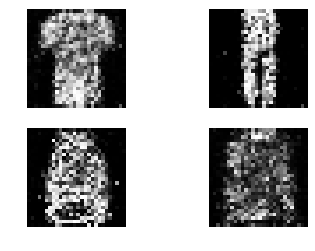

3901 [D loss: 0.603388, acc.: 65.62%] [G loss: 0.925636]
3902 [D loss: 0.625865, acc.: 57.81%] [G loss: 0.947646]
3903 [D loss: 0.709170, acc.: 53.12%] [G loss: 0.958207]
3904 [D loss: 0.570288, acc.: 67.19%] [G loss: 0.967610]
3905 [D loss: 0.674489, acc.: 54.69%] [G loss: 0.954585]
3906 [D loss: 0.622510, acc.: 73.44%] [G loss: 0.926766]
3907 [D loss: 0.686822, acc.: 51.56%] [G loss: 0.870987]
3908 [D loss: 0.640184, acc.: 56.25%] [G loss: 0.872343]
3909 [D loss: 0.636893, acc.: 60.94%] [G loss: 0.858006]
3910 [D loss: 0.613939, acc.: 67.19%] [G loss: 0.971947]
3911 [D loss: 0.670192, acc.: 53.12%] [G loss: 0.938275]
3912 [D loss: 0.616580, acc.: 59.38%] [G loss: 0.902577]
3913 [D loss: 0.576868, acc.: 71.88%] [G loss: 1.034651]
3914 [D loss: 0.678801, acc.: 54.69%] [G loss: 0.981237]
3915 [D loss: 0.644290, acc.: 65.62%] [G loss: 1.060376]
3916 [D loss: 0.663556, acc.: 56.25%] [G loss: 0.910987]
3917 [D loss: 0.674657, acc.: 62.50%] [G loss: 0.884717]
3918 [D loss: 0.573547, acc.: 7

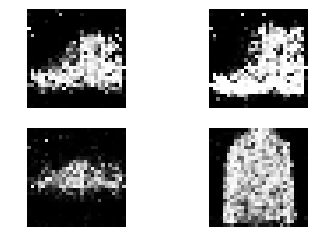

4201 [D loss: 0.662958, acc.: 57.81%] [G loss: 0.907851]
4202 [D loss: 0.673407, acc.: 54.69%] [G loss: 0.864791]
4203 [D loss: 0.642146, acc.: 56.25%] [G loss: 0.911245]
4204 [D loss: 0.654438, acc.: 60.94%] [G loss: 0.881433]
4205 [D loss: 0.683053, acc.: 64.06%] [G loss: 0.857555]
4206 [D loss: 0.648878, acc.: 57.81%] [G loss: 0.925210]
4207 [D loss: 0.685554, acc.: 50.00%] [G loss: 0.900855]
4208 [D loss: 0.664897, acc.: 54.69%] [G loss: 0.969575]
4209 [D loss: 0.670771, acc.: 51.56%] [G loss: 0.897160]
4210 [D loss: 0.641109, acc.: 57.81%] [G loss: 1.026180]
4211 [D loss: 0.685079, acc.: 56.25%] [G loss: 1.040896]
4212 [D loss: 0.691009, acc.: 54.69%] [G loss: 1.014887]
4213 [D loss: 0.657120, acc.: 54.69%] [G loss: 0.938275]
4214 [D loss: 0.620260, acc.: 68.75%] [G loss: 0.957760]
4215 [D loss: 0.643995, acc.: 56.25%] [G loss: 0.968971]
4216 [D loss: 0.644770, acc.: 56.25%] [G loss: 0.932304]
4217 [D loss: 0.622078, acc.: 54.69%] [G loss: 0.920517]
4218 [D loss: 0.623646, acc.: 6

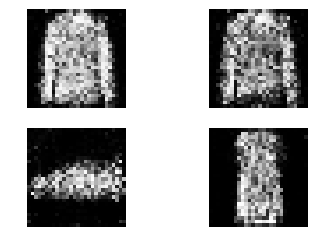

4501 [D loss: 0.637308, acc.: 62.50%] [G loss: 0.957277]
4502 [D loss: 0.654887, acc.: 57.81%] [G loss: 0.950106]
4503 [D loss: 0.622137, acc.: 64.06%] [G loss: 0.973685]
4504 [D loss: 0.571571, acc.: 71.88%] [G loss: 0.967340]
4505 [D loss: 0.606926, acc.: 62.50%] [G loss: 1.013103]
4506 [D loss: 0.639283, acc.: 62.50%] [G loss: 0.999107]
4507 [D loss: 0.640287, acc.: 57.81%] [G loss: 1.049512]
4508 [D loss: 0.634010, acc.: 64.06%] [G loss: 0.917609]
4509 [D loss: 0.680875, acc.: 56.25%] [G loss: 0.892256]
4510 [D loss: 0.634391, acc.: 62.50%] [G loss: 0.929672]
4511 [D loss: 0.659963, acc.: 64.06%] [G loss: 0.951140]
4512 [D loss: 0.612808, acc.: 65.62%] [G loss: 0.915180]
4513 [D loss: 0.623153, acc.: 60.94%] [G loss: 1.041714]
4514 [D loss: 0.633576, acc.: 60.94%] [G loss: 0.993883]
4515 [D loss: 0.627406, acc.: 57.81%] [G loss: 0.950695]
4516 [D loss: 0.674531, acc.: 56.25%] [G loss: 0.966520]
4517 [D loss: 0.615059, acc.: 57.81%] [G loss: 1.000553]
4518 [D loss: 0.644122, acc.: 5

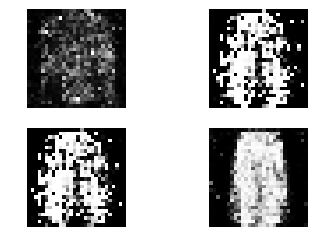

4801 [D loss: 0.581353, acc.: 67.19%] [G loss: 0.950389]
4802 [D loss: 0.654316, acc.: 57.81%] [G loss: 0.867372]
4803 [D loss: 0.647758, acc.: 54.69%] [G loss: 0.880116]
4804 [D loss: 0.646278, acc.: 57.81%] [G loss: 0.945167]
4805 [D loss: 0.634513, acc.: 51.56%] [G loss: 0.925934]
4806 [D loss: 0.662639, acc.: 53.12%] [G loss: 0.968143]
4807 [D loss: 0.616857, acc.: 68.75%] [G loss: 0.930075]
4808 [D loss: 0.678373, acc.: 53.12%] [G loss: 0.976487]
4809 [D loss: 0.626889, acc.: 64.06%] [G loss: 0.951445]
4810 [D loss: 0.635412, acc.: 62.50%] [G loss: 0.887052]
4811 [D loss: 0.624409, acc.: 60.94%] [G loss: 0.890880]
4812 [D loss: 0.643481, acc.: 67.19%] [G loss: 0.913875]
4813 [D loss: 0.648836, acc.: 54.69%] [G loss: 0.816227]
4814 [D loss: 0.695098, acc.: 46.88%] [G loss: 0.871564]
4815 [D loss: 0.609435, acc.: 57.81%] [G loss: 0.873216]
4816 [D loss: 0.659141, acc.: 59.38%] [G loss: 0.929696]
4817 [D loss: 0.666320, acc.: 67.19%] [G loss: 0.859716]
4818 [D loss: 0.619544, acc.: 6

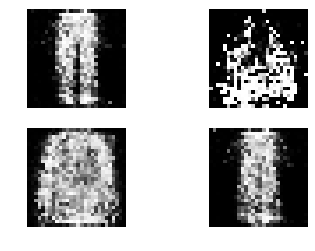

5101 [D loss: 0.623228, acc.: 54.69%] [G loss: 0.995644]
5102 [D loss: 0.666509, acc.: 57.81%] [G loss: 0.903136]
5103 [D loss: 0.713999, acc.: 45.31%] [G loss: 0.900172]
5104 [D loss: 0.632328, acc.: 56.25%] [G loss: 0.873201]
5105 [D loss: 0.640195, acc.: 53.12%] [G loss: 0.821509]
5106 [D loss: 0.643727, acc.: 59.38%] [G loss: 0.873860]
5107 [D loss: 0.629874, acc.: 67.19%] [G loss: 0.851608]
5108 [D loss: 0.639228, acc.: 54.69%] [G loss: 0.872098]
5109 [D loss: 0.674650, acc.: 59.38%] [G loss: 0.884851]
5110 [D loss: 0.643705, acc.: 62.50%] [G loss: 0.852585]
5111 [D loss: 0.666633, acc.: 48.44%] [G loss: 0.824103]
5112 [D loss: 0.687452, acc.: 54.69%] [G loss: 0.916151]
5113 [D loss: 0.636957, acc.: 50.00%] [G loss: 0.913085]
5114 [D loss: 0.666918, acc.: 46.88%] [G loss: 0.935081]
5115 [D loss: 0.644487, acc.: 67.19%] [G loss: 0.904014]
5116 [D loss: 0.617298, acc.: 54.69%] [G loss: 1.024090]
5117 [D loss: 0.627482, acc.: 68.75%] [G loss: 0.995445]
5118 [D loss: 0.698476, acc.: 5

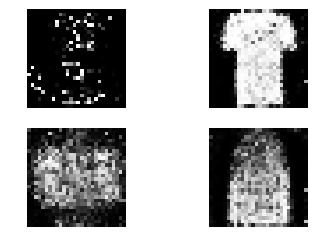

5401 [D loss: 0.648790, acc.: 62.50%] [G loss: 0.830263]
5402 [D loss: 0.645548, acc.: 59.38%] [G loss: 0.929420]
5403 [D loss: 0.702304, acc.: 46.88%] [G loss: 0.833565]
5404 [D loss: 0.639808, acc.: 67.19%] [G loss: 0.850105]
5405 [D loss: 0.702532, acc.: 53.12%] [G loss: 0.847290]
5406 [D loss: 0.647409, acc.: 64.06%] [G loss: 0.867886]
5407 [D loss: 0.641264, acc.: 54.69%] [G loss: 0.877744]
5408 [D loss: 0.669224, acc.: 54.69%] [G loss: 0.856737]
5409 [D loss: 0.680513, acc.: 57.81%] [G loss: 0.870402]
5410 [D loss: 0.688445, acc.: 50.00%] [G loss: 0.930302]
5411 [D loss: 0.648390, acc.: 57.81%] [G loss: 0.859420]
5412 [D loss: 0.708454, acc.: 51.56%] [G loss: 0.828432]
5413 [D loss: 0.644450, acc.: 68.75%] [G loss: 0.850979]
5414 [D loss: 0.668024, acc.: 59.38%] [G loss: 0.798819]
5415 [D loss: 0.640184, acc.: 65.62%] [G loss: 0.823799]
5416 [D loss: 0.599131, acc.: 65.62%] [G loss: 0.852945]
5417 [D loss: 0.643480, acc.: 53.12%] [G loss: 0.869176]
5418 [D loss: 0.711515, acc.: 5

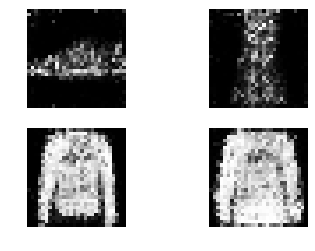

5701 [D loss: 0.631827, acc.: 59.38%] [G loss: 0.790796]
5702 [D loss: 0.676312, acc.: 56.25%] [G loss: 0.797904]
5703 [D loss: 0.705670, acc.: 50.00%] [G loss: 0.805030]
5704 [D loss: 0.652238, acc.: 64.06%] [G loss: 0.814684]
5705 [D loss: 0.730345, acc.: 46.88%] [G loss: 0.810978]
5706 [D loss: 0.718805, acc.: 42.19%] [G loss: 0.914429]
5707 [D loss: 0.648012, acc.: 60.94%] [G loss: 0.916328]
5708 [D loss: 0.716495, acc.: 53.12%] [G loss: 0.875727]
5709 [D loss: 0.701226, acc.: 50.00%] [G loss: 0.872992]
5710 [D loss: 0.710765, acc.: 50.00%] [G loss: 0.834235]
5711 [D loss: 0.650850, acc.: 62.50%] [G loss: 0.913907]
5712 [D loss: 0.676479, acc.: 57.81%] [G loss: 0.822272]
5713 [D loss: 0.701977, acc.: 60.94%] [G loss: 0.835493]
5714 [D loss: 0.676447, acc.: 51.56%] [G loss: 0.803650]
5715 [D loss: 0.672945, acc.: 53.12%] [G loss: 0.829231]
5716 [D loss: 0.642687, acc.: 54.69%] [G loss: 0.823614]
5717 [D loss: 0.675600, acc.: 57.81%] [G loss: 0.796272]
5718 [D loss: 0.614815, acc.: 6

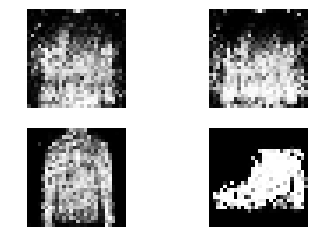

6001 [D loss: 0.672200, acc.: 51.56%] [G loss: 0.838313]
6002 [D loss: 0.654262, acc.: 57.81%] [G loss: 0.843898]
6003 [D loss: 0.673856, acc.: 46.88%] [G loss: 0.739806]
6004 [D loss: 0.611532, acc.: 65.62%] [G loss: 0.829728]
6005 [D loss: 0.700666, acc.: 45.31%] [G loss: 0.835515]
6006 [D loss: 0.735558, acc.: 42.19%] [G loss: 0.885574]
6007 [D loss: 0.693239, acc.: 50.00%] [G loss: 0.934481]
6008 [D loss: 0.719561, acc.: 43.75%] [G loss: 0.894977]
6009 [D loss: 0.737280, acc.: 51.56%] [G loss: 0.852973]
6010 [D loss: 0.694978, acc.: 50.00%] [G loss: 0.858065]
6011 [D loss: 0.656485, acc.: 64.06%] [G loss: 0.794072]
6012 [D loss: 0.677519, acc.: 59.38%] [G loss: 0.812794]
6013 [D loss: 0.647940, acc.: 60.94%] [G loss: 0.839270]
6014 [D loss: 0.645117, acc.: 60.94%] [G loss: 0.858848]
6015 [D loss: 0.626240, acc.: 60.94%] [G loss: 0.942484]
6016 [D loss: 0.666680, acc.: 51.56%] [G loss: 0.945280]
6017 [D loss: 0.736644, acc.: 45.31%] [G loss: 0.835981]
6018 [D loss: 0.685787, acc.: 4

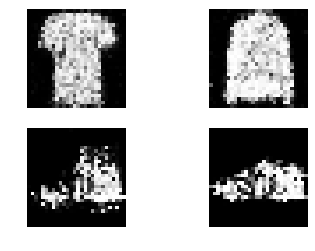

6301 [D loss: 0.693457, acc.: 54.69%] [G loss: 0.852609]
6302 [D loss: 0.640819, acc.: 57.81%] [G loss: 0.787533]
6303 [D loss: 0.710681, acc.: 51.56%] [G loss: 0.911709]
6304 [D loss: 0.658727, acc.: 59.38%] [G loss: 0.862104]
6305 [D loss: 0.610687, acc.: 64.06%] [G loss: 0.916077]
6306 [D loss: 0.671169, acc.: 57.81%] [G loss: 0.908949]
6307 [D loss: 0.652870, acc.: 59.38%] [G loss: 0.911813]
6308 [D loss: 0.683349, acc.: 57.81%] [G loss: 0.825709]
6309 [D loss: 0.634909, acc.: 64.06%] [G loss: 0.876290]
6310 [D loss: 0.642091, acc.: 60.94%] [G loss: 0.794385]
6311 [D loss: 0.662411, acc.: 59.38%] [G loss: 0.826399]
6312 [D loss: 0.649779, acc.: 60.94%] [G loss: 0.885834]
6313 [D loss: 0.645115, acc.: 57.81%] [G loss: 0.934729]
6314 [D loss: 0.682052, acc.: 60.94%] [G loss: 0.837882]
6315 [D loss: 0.701057, acc.: 50.00%] [G loss: 0.794679]
6316 [D loss: 0.683016, acc.: 53.12%] [G loss: 0.740824]
6317 [D loss: 0.721673, acc.: 48.44%] [G loss: 0.793703]
6318 [D loss: 0.689326, acc.: 5

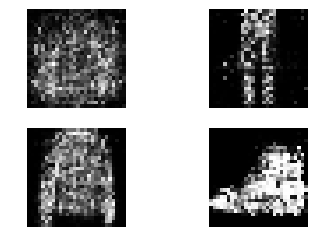

6601 [D loss: 0.633355, acc.: 54.69%] [G loss: 0.919739]
6602 [D loss: 0.689245, acc.: 53.12%] [G loss: 0.892934]
6603 [D loss: 0.653978, acc.: 64.06%] [G loss: 0.822927]
6604 [D loss: 0.647941, acc.: 60.94%] [G loss: 0.803959]
6605 [D loss: 0.643192, acc.: 62.50%] [G loss: 0.747048]
6606 [D loss: 0.668291, acc.: 62.50%] [G loss: 0.802448]
6607 [D loss: 0.733347, acc.: 42.19%] [G loss: 0.814210]
6608 [D loss: 0.685794, acc.: 53.12%] [G loss: 0.764024]
6609 [D loss: 0.709811, acc.: 56.25%] [G loss: 0.892536]
6610 [D loss: 0.596713, acc.: 71.88%] [G loss: 0.971784]
6611 [D loss: 0.757822, acc.: 43.75%] [G loss: 0.852954]
6612 [D loss: 0.660644, acc.: 54.69%] [G loss: 0.791342]
6613 [D loss: 0.638338, acc.: 67.19%] [G loss: 0.831597]
6614 [D loss: 0.645047, acc.: 59.38%] [G loss: 0.905619]
6615 [D loss: 0.703039, acc.: 56.25%] [G loss: 0.866770]
6616 [D loss: 0.676141, acc.: 51.56%] [G loss: 0.926278]
6617 [D loss: 0.628515, acc.: 56.25%] [G loss: 0.843553]
6618 [D loss: 0.685208, acc.: 6

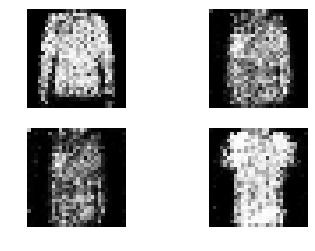

6901 [D loss: 0.664789, acc.: 60.94%] [G loss: 0.860872]
6902 [D loss: 0.672927, acc.: 56.25%] [G loss: 0.816665]
6903 [D loss: 0.666090, acc.: 56.25%] [G loss: 0.889920]
6904 [D loss: 0.639231, acc.: 68.75%] [G loss: 0.877622]
6905 [D loss: 0.644913, acc.: 67.19%] [G loss: 0.838081]
6906 [D loss: 0.678142, acc.: 53.12%] [G loss: 0.842346]
6907 [D loss: 0.662354, acc.: 59.38%] [G loss: 0.864453]
6908 [D loss: 0.667451, acc.: 54.69%] [G loss: 0.834667]
6909 [D loss: 0.624334, acc.: 62.50%] [G loss: 0.860834]
6910 [D loss: 0.679499, acc.: 59.38%] [G loss: 0.832346]
6911 [D loss: 0.703656, acc.: 50.00%] [G loss: 0.814728]
6912 [D loss: 0.649184, acc.: 60.94%] [G loss: 0.860544]
6913 [D loss: 0.659561, acc.: 59.38%] [G loss: 0.805963]
6914 [D loss: 0.649889, acc.: 60.94%] [G loss: 0.804704]
6915 [D loss: 0.683890, acc.: 54.69%] [G loss: 0.845015]
6916 [D loss: 0.628310, acc.: 67.19%] [G loss: 0.862777]
6917 [D loss: 0.653051, acc.: 62.50%] [G loss: 0.922496]
6918 [D loss: 0.734037, acc.: 5

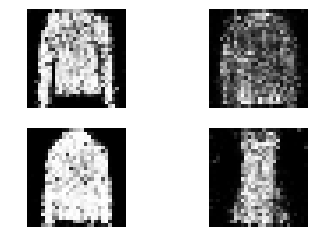

7201 [D loss: 0.619827, acc.: 75.00%] [G loss: 0.788033]
7202 [D loss: 0.673458, acc.: 53.12%] [G loss: 0.855067]
7203 [D loss: 0.649475, acc.: 59.38%] [G loss: 0.788683]
7204 [D loss: 0.662493, acc.: 59.38%] [G loss: 0.815340]
7205 [D loss: 0.656581, acc.: 59.38%] [G loss: 0.859509]
7206 [D loss: 0.642914, acc.: 60.94%] [G loss: 0.799319]
7207 [D loss: 0.737507, acc.: 45.31%] [G loss: 0.839152]
7208 [D loss: 0.644871, acc.: 67.19%] [G loss: 0.855489]
7209 [D loss: 0.680496, acc.: 48.44%] [G loss: 0.901507]
7210 [D loss: 0.680064, acc.: 62.50%] [G loss: 1.011379]
7211 [D loss: 0.699379, acc.: 50.00%] [G loss: 0.904333]
7212 [D loss: 0.645491, acc.: 64.06%] [G loss: 0.854970]
7213 [D loss: 0.660668, acc.: 59.38%] [G loss: 0.883388]
7214 [D loss: 0.644169, acc.: 68.75%] [G loss: 0.832646]
7215 [D loss: 0.619249, acc.: 64.06%] [G loss: 0.885864]
7216 [D loss: 0.659784, acc.: 53.12%] [G loss: 0.906434]
7217 [D loss: 0.654291, acc.: 65.62%] [G loss: 0.933954]
7218 [D loss: 0.675529, acc.: 6

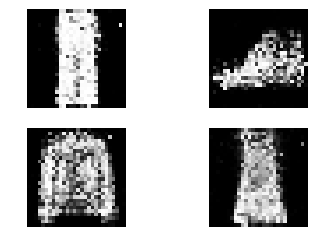

7501 [D loss: 0.687190, acc.: 54.69%] [G loss: 0.854635]
7502 [D loss: 0.655656, acc.: 59.38%] [G loss: 0.846004]
7503 [D loss: 0.673054, acc.: 60.94%] [G loss: 0.901368]
7504 [D loss: 0.681262, acc.: 60.94%] [G loss: 0.970970]
7505 [D loss: 0.621957, acc.: 67.19%] [G loss: 0.924772]
7506 [D loss: 0.641393, acc.: 57.81%] [G loss: 0.910091]
7507 [D loss: 0.656156, acc.: 57.81%] [G loss: 0.858862]
7508 [D loss: 0.623017, acc.: 62.50%] [G loss: 0.958586]
7509 [D loss: 0.650967, acc.: 65.62%] [G loss: 0.905719]
7510 [D loss: 0.680948, acc.: 51.56%] [G loss: 0.876842]
7511 [D loss: 0.614064, acc.: 68.75%] [G loss: 0.972914]
7512 [D loss: 0.623133, acc.: 60.94%] [G loss: 0.927476]
7513 [D loss: 0.649627, acc.: 59.38%] [G loss: 0.869046]
7514 [D loss: 0.689221, acc.: 46.88%] [G loss: 0.860432]
7515 [D loss: 0.589999, acc.: 67.19%] [G loss: 0.858215]
7516 [D loss: 0.596694, acc.: 64.06%] [G loss: 0.896781]
7517 [D loss: 0.648888, acc.: 57.81%] [G loss: 0.998368]
7518 [D loss: 0.640586, acc.: 6

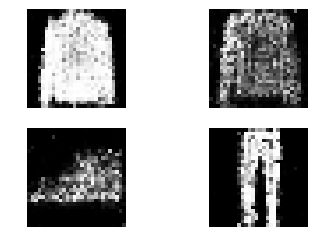

7801 [D loss: 0.657662, acc.: 56.25%] [G loss: 0.906539]
7802 [D loss: 0.694108, acc.: 48.44%] [G loss: 0.882356]
7803 [D loss: 0.677467, acc.: 64.06%] [G loss: 0.915782]
7804 [D loss: 0.655354, acc.: 68.75%] [G loss: 0.907860]
7805 [D loss: 0.638569, acc.: 70.31%] [G loss: 1.027353]
7806 [D loss: 0.672179, acc.: 57.81%] [G loss: 0.999108]
7807 [D loss: 0.698579, acc.: 59.38%] [G loss: 0.836239]
7808 [D loss: 0.685512, acc.: 48.44%] [G loss: 0.888400]
7809 [D loss: 0.654408, acc.: 60.94%] [G loss: 0.890827]
7810 [D loss: 0.630885, acc.: 64.06%] [G loss: 0.891604]
7811 [D loss: 0.674225, acc.: 53.12%] [G loss: 0.858028]
7812 [D loss: 0.640595, acc.: 60.94%] [G loss: 0.871057]
7813 [D loss: 0.628020, acc.: 60.94%] [G loss: 0.898596]
7814 [D loss: 0.667966, acc.: 50.00%] [G loss: 0.788349]
7815 [D loss: 0.672177, acc.: 62.50%] [G loss: 0.833703]
7816 [D loss: 0.667293, acc.: 67.19%] [G loss: 0.755924]
7817 [D loss: 0.692617, acc.: 46.88%] [G loss: 0.893292]
7818 [D loss: 0.692770, acc.: 5

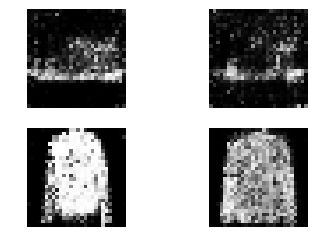

8101 [D loss: 0.660828, acc.: 62.50%] [G loss: 0.796630]
8102 [D loss: 0.663972, acc.: 56.25%] [G loss: 0.860081]
8103 [D loss: 0.660629, acc.: 60.94%] [G loss: 0.887502]
8104 [D loss: 0.690373, acc.: 54.69%] [G loss: 0.925224]
8105 [D loss: 0.653890, acc.: 54.69%] [G loss: 0.964345]
8106 [D loss: 0.655242, acc.: 62.50%] [G loss: 0.881738]
8107 [D loss: 0.642100, acc.: 56.25%] [G loss: 0.873100]
8108 [D loss: 0.653006, acc.: 54.69%] [G loss: 0.869622]
8109 [D loss: 0.704029, acc.: 62.50%] [G loss: 0.853606]
8110 [D loss: 0.692365, acc.: 48.44%] [G loss: 0.843934]
8111 [D loss: 0.657187, acc.: 57.81%] [G loss: 0.947396]
8112 [D loss: 0.727825, acc.: 40.62%] [G loss: 0.861329]
8113 [D loss: 0.682359, acc.: 54.69%] [G loss: 0.885814]
8114 [D loss: 0.678724, acc.: 51.56%] [G loss: 0.800357]
8115 [D loss: 0.641487, acc.: 56.25%] [G loss: 0.852656]
8116 [D loss: 0.704006, acc.: 51.56%] [G loss: 0.873795]
8117 [D loss: 0.630272, acc.: 64.06%] [G loss: 0.829304]
8118 [D loss: 0.711692, acc.: 5

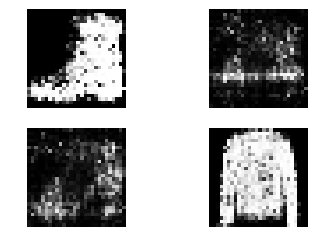

8401 [D loss: 0.654711, acc.: 62.50%] [G loss: 0.888999]
8402 [D loss: 0.629102, acc.: 65.62%] [G loss: 0.943714]
8403 [D loss: 0.622914, acc.: 70.31%] [G loss: 0.917473]
8404 [D loss: 0.702531, acc.: 50.00%] [G loss: 0.866931]
8405 [D loss: 0.630958, acc.: 65.62%] [G loss: 0.859399]
8406 [D loss: 0.697555, acc.: 51.56%] [G loss: 0.848619]
8407 [D loss: 0.719183, acc.: 48.44%] [G loss: 0.825451]
8408 [D loss: 0.718794, acc.: 43.75%] [G loss: 0.876762]
8409 [D loss: 0.659954, acc.: 62.50%] [G loss: 0.860350]
8410 [D loss: 0.683183, acc.: 50.00%] [G loss: 0.850803]
8411 [D loss: 0.705568, acc.: 45.31%] [G loss: 0.777302]
8412 [D loss: 0.657926, acc.: 53.12%] [G loss: 0.796293]
8413 [D loss: 0.694936, acc.: 53.12%] [G loss: 0.789859]
8414 [D loss: 0.694349, acc.: 48.44%] [G loss: 0.853514]
8415 [D loss: 0.642791, acc.: 64.06%] [G loss: 0.840713]
8416 [D loss: 0.675087, acc.: 54.69%] [G loss: 0.838256]
8417 [D loss: 0.620042, acc.: 59.38%] [G loss: 0.789451]
8418 [D loss: 0.677830, acc.: 5

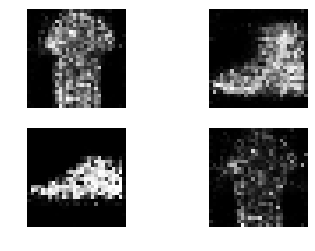

8701 [D loss: 0.684948, acc.: 53.12%] [G loss: 0.851114]
8702 [D loss: 0.617840, acc.: 71.88%] [G loss: 0.854454]
8703 [D loss: 0.670983, acc.: 60.94%] [G loss: 0.903261]
8704 [D loss: 0.615886, acc.: 62.50%] [G loss: 0.810769]
8705 [D loss: 0.657693, acc.: 57.81%] [G loss: 0.853002]
8706 [D loss: 0.679165, acc.: 60.94%] [G loss: 0.856555]
8707 [D loss: 0.696340, acc.: 51.56%] [G loss: 0.844587]
8708 [D loss: 0.654648, acc.: 64.06%] [G loss: 0.860846]
8709 [D loss: 0.662732, acc.: 62.50%] [G loss: 0.877967]
8710 [D loss: 0.701031, acc.: 50.00%] [G loss: 0.892159]
8711 [D loss: 0.677942, acc.: 57.81%] [G loss: 0.881510]
8712 [D loss: 0.673773, acc.: 53.12%] [G loss: 0.835014]
8713 [D loss: 0.673712, acc.: 62.50%] [G loss: 0.852252]
8714 [D loss: 0.706086, acc.: 48.44%] [G loss: 0.825518]
8715 [D loss: 0.656378, acc.: 56.25%] [G loss: 0.821807]
8716 [D loss: 0.689764, acc.: 45.31%] [G loss: 0.835082]
8717 [D loss: 0.705940, acc.: 43.75%] [G loss: 0.797012]
8718 [D loss: 0.650508, acc.: 6

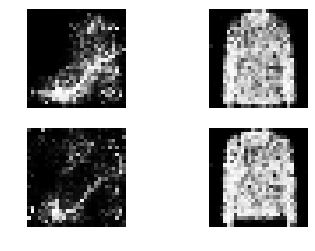

9001 [D loss: 0.681155, acc.: 56.25%] [G loss: 0.842845]
9002 [D loss: 0.726508, acc.: 51.56%] [G loss: 0.851438]
9003 [D loss: 0.672398, acc.: 56.25%] [G loss: 0.926843]
9004 [D loss: 0.664188, acc.: 54.69%] [G loss: 0.851330]
9005 [D loss: 0.693163, acc.: 53.12%] [G loss: 0.832576]
9006 [D loss: 0.694768, acc.: 50.00%] [G loss: 0.891134]
9007 [D loss: 0.726704, acc.: 46.88%] [G loss: 0.785915]
9008 [D loss: 0.684697, acc.: 57.81%] [G loss: 0.856967]
9009 [D loss: 0.675016, acc.: 57.81%] [G loss: 0.849529]
9010 [D loss: 0.678577, acc.: 54.69%] [G loss: 0.847622]
9011 [D loss: 0.707234, acc.: 48.44%] [G loss: 0.865104]
9012 [D loss: 0.634285, acc.: 65.62%] [G loss: 0.912677]
9013 [D loss: 0.654065, acc.: 60.94%] [G loss: 0.914907]
9014 [D loss: 0.683079, acc.: 59.38%] [G loss: 0.852300]
9015 [D loss: 0.639693, acc.: 60.94%] [G loss: 0.879784]
9016 [D loss: 0.691974, acc.: 46.88%] [G loss: 0.892794]
9017 [D loss: 0.749403, acc.: 42.19%] [G loss: 0.822541]
9018 [D loss: 0.670273, acc.: 4

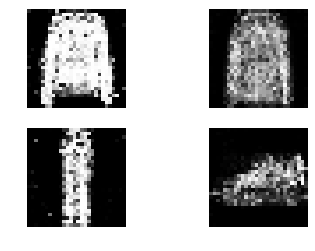

9301 [D loss: 0.701239, acc.: 50.00%] [G loss: 0.901811]
9302 [D loss: 0.639267, acc.: 62.50%] [G loss: 0.928377]
9303 [D loss: 0.672432, acc.: 59.38%] [G loss: 0.817787]
9304 [D loss: 0.598579, acc.: 71.88%] [G loss: 0.943967]
9305 [D loss: 0.678380, acc.: 51.56%] [G loss: 0.856505]
9306 [D loss: 0.693340, acc.: 51.56%] [G loss: 0.828049]
9307 [D loss: 0.659270, acc.: 54.69%] [G loss: 0.835141]
9308 [D loss: 0.695175, acc.: 56.25%] [G loss: 0.890156]
9309 [D loss: 0.692104, acc.: 45.31%] [G loss: 0.869514]
9310 [D loss: 0.707770, acc.: 48.44%] [G loss: 0.845941]
9311 [D loss: 0.633846, acc.: 64.06%] [G loss: 0.792258]
9312 [D loss: 0.628375, acc.: 75.00%] [G loss: 0.874613]
9313 [D loss: 0.657182, acc.: 67.19%] [G loss: 0.869945]
9314 [D loss: 0.636339, acc.: 64.06%] [G loss: 0.943182]
9315 [D loss: 0.659944, acc.: 54.69%] [G loss: 0.808404]
9316 [D loss: 0.646061, acc.: 59.38%] [G loss: 0.834194]
9317 [D loss: 0.671709, acc.: 54.69%] [G loss: 0.833498]
9318 [D loss: 0.697609, acc.: 5

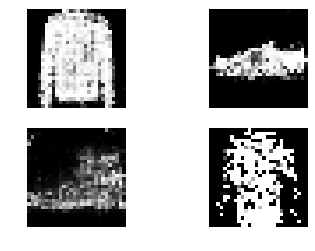

9601 [D loss: 0.703156, acc.: 53.12%] [G loss: 0.802126]
9602 [D loss: 0.659766, acc.: 70.31%] [G loss: 0.841516]
9603 [D loss: 0.667322, acc.: 60.94%] [G loss: 0.797397]
9604 [D loss: 0.685020, acc.: 62.50%] [G loss: 0.900096]
9605 [D loss: 0.705786, acc.: 57.81%] [G loss: 0.869885]
9606 [D loss: 0.695254, acc.: 48.44%] [G loss: 0.913320]
9607 [D loss: 0.681846, acc.: 59.38%] [G loss: 0.883570]
9608 [D loss: 0.691247, acc.: 53.12%] [G loss: 0.802186]
9609 [D loss: 0.697758, acc.: 53.12%] [G loss: 0.850488]
9610 [D loss: 0.693605, acc.: 53.12%] [G loss: 0.849190]
9611 [D loss: 0.664830, acc.: 53.12%] [G loss: 0.871964]
9612 [D loss: 0.675440, acc.: 56.25%] [G loss: 0.821050]
9613 [D loss: 0.661972, acc.: 54.69%] [G loss: 0.898144]
9614 [D loss: 0.625726, acc.: 71.88%] [G loss: 0.872445]
9615 [D loss: 0.691453, acc.: 56.25%] [G loss: 0.869905]
9616 [D loss: 0.660943, acc.: 57.81%] [G loss: 0.812015]
9617 [D loss: 0.668462, acc.: 57.81%] [G loss: 0.802336]
9618 [D loss: 0.685129, acc.: 5

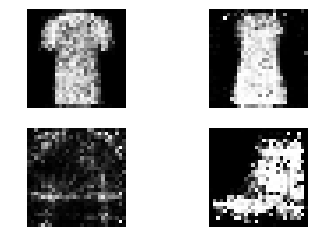

9901 [D loss: 0.680651, acc.: 56.25%] [G loss: 0.924185]
9902 [D loss: 0.660102, acc.: 60.94%] [G loss: 0.876536]
9903 [D loss: 0.684721, acc.: 51.56%] [G loss: 0.897200]
9904 [D loss: 0.731345, acc.: 46.88%] [G loss: 0.873395]
9905 [D loss: 0.660016, acc.: 57.81%] [G loss: 0.856706]
9906 [D loss: 0.619166, acc.: 64.06%] [G loss: 0.896503]
9907 [D loss: 0.641973, acc.: 56.25%] [G loss: 0.825991]
9908 [D loss: 0.717454, acc.: 42.19%] [G loss: 0.865829]
9909 [D loss: 0.654145, acc.: 62.50%] [G loss: 0.885037]
9910 [D loss: 0.686078, acc.: 56.25%] [G loss: 0.902924]
9911 [D loss: 0.652439, acc.: 57.81%] [G loss: 0.937364]
9912 [D loss: 0.678743, acc.: 59.38%] [G loss: 0.776130]
9913 [D loss: 0.721505, acc.: 53.12%] [G loss: 0.849199]
9914 [D loss: 0.652995, acc.: 67.19%] [G loss: 0.846164]
9915 [D loss: 0.668386, acc.: 59.38%] [G loss: 0.886881]
9916 [D loss: 0.639075, acc.: 65.62%] [G loss: 0.863292]
9917 [D loss: 0.649620, acc.: 71.88%] [G loss: 0.913054]
9918 [D loss: 0.695281, acc.: 5

In [18]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10000, batch_size=32, sample_interval=300)